In [85]:
using NBInclude
using Plots
using LaTeXStrings
using SparseArrays
using DataFrames
using ProgressBars
using Interpolations
using LinearAlgebra
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"))
@nbinclude("../Hofstadter Many Body Utils.ipynb")
@nbinclude(joinpath("../Braiding Utils.ipynb"))
@nbinclude("Torus_Distance.ipynb");

In [86]:
Nx=8
Ny=10
N=Nx*Ny
p=1
q=Ny
NPhi = Int( Nx * Ny * (p/q) )
cut_off = NPhi
PN = [0, 1, 2, 3]
U=2;

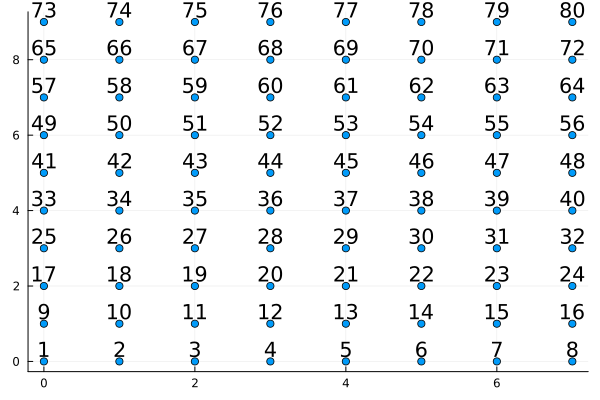

([0 0; 1 0; … ; 6 9; 7 9], nothing)

In [7]:
plot_square_lattice(Nx, Ny)

In [26]:
V_Strength = 4
V0 = [V_Strength, 
      0*V_Strength]
Imp_Site = [36, 19]
N_Pin = 1 # Number of pinning quasihole
Impurity_Data = Impurity(V0, Imp_Site)
factor = 5; # particle density interpolation factor

0.0%┣                                                ┫ 0/8 [00:00<00:00, -0s/it]
62.5%┣█████████████████████████████▍                 ┫ 5/8 [00:00<00:00, 68it/s]
100.0%┣██████████████████████████████████████████████┫ 8/8 [00:00<00:00, 73it/s]
100.0%┣██████████████████████████████████████████████┫ 8/8 [00:00<00:00, 73it/s]
0.0%┣                                               ┫ 0/80 [00:00<00:00, -0s/it]
100.0%┣██████████████████████████████████████████┫ 80/80 [00:00<00:00, 5.8kit/s]
100.0%┣██████████████████████████████████████████┫ 80/80 [00:00<00:00, 5.8kit/s]


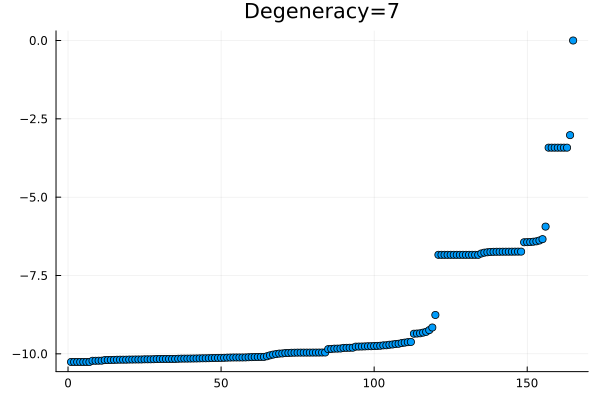

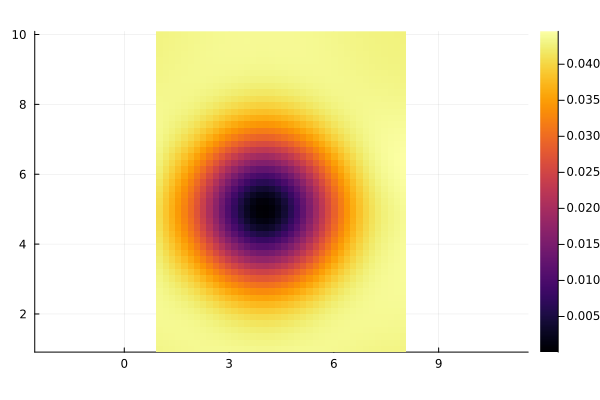

In [38]:
E, Sub_Number_MB_Operator_List, basis_cut_mb, Degeneracy, Total_H, Sub_Number_MB_Operator_List, r_hubbard_states,pn, NPhi0 = Get_MB(N, Nx, Ny, p, q, cut_off, PN, U, Impurity_Data);

In [144]:
# Torus Distance and Equivalent (Periodic) Sites
@nbinclude("Torus_Distance.ipynb");

In [177]:
coordinates, latticee = get_square_lattice(Nx, Ny)
coordinates_top_left, coordinates_top, coordinates_top_right, coordinates_left, coordinates_right, coordinates_bottom_left, coordinates_bottom, coordinates_bottom_right, co_districts = get_ghost_sites(coordinates)
ref_coordinates = coordinates
ref_site = 10 # Site Pinned (Site 44 = Site 36) for Inner_Sites function (It's not general form)
# GÜNCELLEME: Inner_Sites -> Inner_Sites2 (General Form)
radius_list = get_radii(ref_coordinates, coordinates, ref_site, N);

In [178]:
All_Coordinates, X_Coordinates, Y_Coordinates, All_Coordinates_2 = get_all_sites(Nx, Ny, coordinates);

In [179]:
# Hangi siteler, ilgili yarı-çap içerisinde, şartını kontrol ediyoruz
function Inner_Sites(Radius)
    
    ref_district = coordinates # Center Distrinct
    Ref_Site_X = ref_district[:,1][ref_site]
    Ref_Site_Y = ref_district[:,2][ref_site]
    
    inner_sites = []
    
    for i in 1:Nx*Ny*9
        
        if (X_Coordinates[i] - Ref_Site_X)^2 + (Y_Coordinates[i] - Ref_Site_Y)^2 < (Radius+0.1)^2
            
            # Yarı-çap büyüdüğünde, periyodik noktalara sıçrayınca, "get_eq_site" fonksiyonu ile eş-değer siteleri buluyoruz.
            push!(inner_sites, get_eq_site(X_Coordinates[i], Y_Coordinates[i]))
        end
    end
    
    return inner_sites
end

Inner_Sites (generic function with 1 method)

In [180]:
coords = get_coords_square(Nx, Ny)

80-element Vector{Any}:
 [0, 0]
 [1, 0]
 [2, 0]
 [3, 0]
 [4, 0]
 [5, 0]
 [6, 0]
 [7, 0]
 [0, 1]
 [1, 1]
 [2, 1]
 [3, 1]
 [4, 1]
 ⋮
 [4, 8]
 [5, 8]
 [6, 8]
 [7, 8]
 [0, 9]
 [1, 9]
 [2, 9]
 [3, 9]
 [4, 9]
 [5, 9]
 [6, 9]
 [7, 9]

In [181]:
function Inner_Sites2(Radius,ref_site,coords)
    
    inner_sites = []
    
    for i in 1:Nx*Ny
        
        Δx = abs(coords[i][1] - coords[ref_site][1])
        Δx = min(Δx,mod(-Δx,Nx-1)+1)

        Δy = abs(coords[i][2] - coords[ref_site][2])
        Δy = min(Δy,mod(-Δy,Ny-1)+1)
        
        if Δx^2 + Δy^2 <= (Radius)^2
            push!(inner_sites, i)
        end
        
    end
    
    return inner_sites
end

Inner_Sites2 (generic function with 3 methods)

In [182]:
Radius = 2
Inner_Sites2(Radius,ref_site,coords)

13-element Vector{Any}:
  1
  2
  3
  9
 10
 11
 12
 16
 17
 18
 19
 26
 74

In [183]:
radius_list

48-element Vector{Any}:
  0.0
  1.0
  1.4142135623730951
  2.0
  2.23606797749979
  2.8284271247461903
  3.0
  3.1622776601683795
  3.605551275463989
  4.0
  4.123105625617661
  4.242640687119285
  4.47213595499958
  ⋮
  9.0
  9.055385138137417
  9.219544457292887
  9.433981132056603
  9.486832980505138
  9.848857801796104
  9.899494936611665
 10.0
 10.295630140987
 10.63014581273465
 10.816653826391969
 11.40175425099138

In [184]:
function get_depletion_profile(radius_list, avg_density)
    
    density_list_1 = []
    density_list_2 = []
    depletion_prof = []
    
    for i in radius_list
        
        summ = 0
    
        for j in Inner_Sites(i)
            
            # r içindeki her bir sitenin ortalama yoğunluğu 
            push!(density_list_1, collect(Iterators.flatten((pn/((NPhi0-1)*Ny) .- avg_density|>transpose)))[j])
            # Örgüde sadece bir tane quasi-parçacık boştayken gelen neredeyse ortalama yoğunluk 3/70'tir!
            
            # aynı yoğunluklar gelirse sadece onların birisini tut
            density_list_2 = unique!(density_list_1)
            
            # her biri biricik ve her bir site için olan yoğunlukları topla
            summ = sum(density_list_2)
        end
        
        # Sitelerin toplam yoğunluklarını bir listede her bir yarı-çap için biriktir
        push!(depletion_prof, summ)
    end
    
    return depletion_prof
end

get_depletion_profile (generic function with 1 method)

In [185]:
function get_depletion_profile2(radius_list, avg_density, ref_site,coords)
    
    density_list_1 = []
    density_list_2 = []
    depletion_prof = []
    
    for i in radius_list
        
        summ = 0
    
        for j in Inner_Sites2(i,ref_site,coords)
            
            # r içindeki her bir sitenin ortalama yoğunluğu 
            push!(density_list_1, collect(Iterators.flatten((pn/((NPhi0-1)*Ny) .- avg_density|>transpose)))[j])
            # Örgüde sadece bir tane quasi-parçacık boştayken gelen neredeyse ortalama yoğunluk 3/70'tir!
            
            # aynı yoğunluklar gelirse sadece onların birisini tut
            density_list_2 = unique!(density_list_1)
            
            # her biri biricik ve her bir site için olan yoğunlukları topla
            summ = sum(density_list_2)
        end
        
        # Sitelerin toplam yoğunluklarını bir listede her bir yarı-çap için biriktir
        push!(depletion_prof, summ)
    end
    
    return depletion_prof
end

get_depletion_profile2 (generic function with 2 methods)

In [186]:
avg_density = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states);

\begin{align*}
&Q_{\rho} = \sum_i \left(<n_i>_{V=0}-<n_i>_{V \neq 0} \right) \\
&\text{Isotropic (uniform) reference particle density:}<n_i>_{V=0} \\
&<n_i>_{V=0} \approx \frac{N}{(N_\phi-1)N_y} = \frac{3}{70} \\
&Q=\frac{N}{N_\phi-1}=\frac{3}{7}
\end{align*}

In [187]:
depletion_prof = get_depletion_profile(radius_list, avg_density)

48-element Vector{Any}:
 -0.00016081599029991317
 -0.0015227877624333433
 -0.00340128587742778
 -0.006051928210894057
 -0.010218343198830894
 -0.008347679609997848
 -0.010687586067700573
 -0.008755504086824711
  0.017584737144172975
  0.018911222299046702
  0.035500747848030346
  0.07231188250710413
  0.12821565621354497
  ⋮
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827

In [188]:
depletion_prof2 = get_depletion_profile2(radius_list, avg_density, ref_site,coords)

48-element Vector{Any}:
 -0.00016081599029991317
 -0.0022695731395650162
 -0.00020669917836422386
  0.03375871056456265
  0.10060079033117353
  0.10372075161814923
  0.15584223917186665
  0.22723830057012584
  0.22723830057012584
  0.26697134711380766
  0.282339996881594
  0.282339996881594
  0.322173412468114
  ⋮
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827
  0.42857142857142827

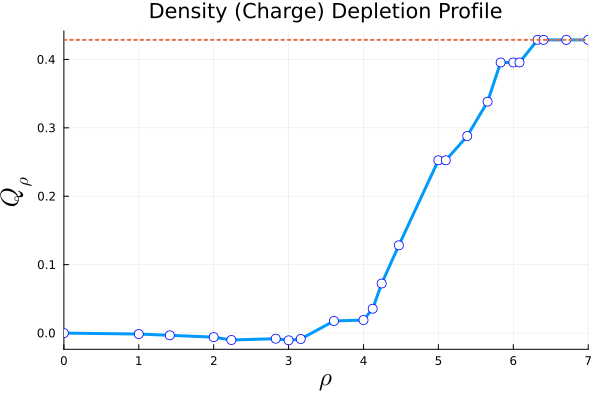

In [189]:
Plots.plot(radius_list, depletion_prof, xlabel=L"\rho", ylabel=L"Q_{\rho}", title="Density (Charge) Depletion Profile", guidefontsize=17,legend=false, linewidth=3, xticks=0:1:12, yticks=0:0.10:0.46, m = (5, :white, stroke(1, :blue)))
Q = pn/(NPhi-1)
g(x)=Q; x=0
Plots.plot!(g, x, length(radius_list), line=(:dot,2), xlim=(0,7))

In [42]:
# NOT quasi particle sadece örgü merkezinde iken yük hesabı doğru. Bunu genelleştirmek lazım!

In [190]:
# GÜNCELLEME: Eş-değer siteleri mod ile seçince, quasiparticle merkezde olmaması sorunu ortadan kalkmadı!